# TO BE DELETED
## Overview
- [DONE] Follow the universal workflow of DLWP 4.5 (1st edition) for a dataset of your choice.
- [DONE] ou can use the tensorflow datasets, MNIST, Reuters, IMDB and Boston Housing Price, or an external dataset. Work exclusively in a Jupyter notebook.
- You can only use DLWP Part 1 layers (Chapters 1 - 4) i.e. restrict your models to tensorflow sequential Dense and Dropout layers.
- Your Jupyter notebook should read as a report, not just a sequence of code cells. Structure your report with markdown headings, subheadings, tables etc.
- You can use as much DLWP code and code from the video notebooks as you wish but you must reference all code that is not original: credit will be given for model assembly using third-party code, and extra credit may be awarded for original code.
- Export your Jupyter notebook to html and submit. Do not submit your notebook or any data files. Submit only the html export of your notebook.

### NOT FOR ME
(For Colab users: Colab does not have an html facility. Either:
- Download the colab notebook and load into Jupyter; you will then be able to export as html OR follow the instructions in this blog i.e. download from colab and then reload into colab's session storage.
- Then run the script: %%shelljupyter nbconvert --to html /Your notebook path/file.ipynb and download the html version)

## REVIEW CRITERIA
Credit will be awarded for:
- report structure and quality as a document
- adherence to the deep learning workflow
- a systematic investigation
- interpretation of results

Additional credit may be awarded for:
- modular programming
- external dataset (but not an online tutorial dataset)
- extensive experimentation
- understanding and technique that exceeds the module syllabus

## DLWP 4.5 CHAPTER SUMMARY
- Define the problem at hand and the data on which you’ll train. Collect this data, or annotate it with labels if need be
- Choose how you’ll measure success on your problem. Which metrics will you monitor on your validation data?
- Determine your evaluation protocol: hold-out validation? K-fold validation? Which portion of the data should you use for validation?
- Develop a first model that does better than a basic baseline: a model with statistical power
- Develop a model that overfits
- Regularize your model and tune its hyperparameters, based on performance on the validation data. A lot of machine-learning research tends to focus only on this step—but keep the big picture in mind

---

# The universal workflow of machine learning
This project centers around the universal workflow of **DLWP 4.5** on the **CIFAR-10** small images classification datatset in Keras. The aim for this project is to produce a model that produces the best results through learning features through Tensorflow's sequential ```Dense``` and ```Dropout``` layers.

## Defining the problem
### Datatype
**Input Data:**
- 60,000 colour images of shape (32, 32, 3)
- Each colour images represents a different object class (vehicles and animals)
- There are 50,000 training images, and 10,000 test images

<br>**Output Data:** A classification label (0-9), representing 10 different categories

<img src="images/CIFAR10_dataset_categories.jpg" style="width: 50%" alt="CIFAR10 Dataset Categories"></img>
<center><b><a href="https://www.cs.toronto.edu/~kriz/cifar.html">1 The CIFAR-10 Dataset Categories</a><b></center>

### Problem Type and Goals
Classification of raw images into categories is valuable across industries. By training a model that could accurately classify images based on features and labels, Machine Learning can be implemented to aid in real-world problems like Breast Cancer Detection. ( **<a href="https://www.nejm.org/doi/full/10.1056/nejmoa1206809">2 Bleyer and Welch, 2012</a>** )

<br>**Problem Type:** Multiclass classification - one of 10 possible classes must be assigned to each one of the 10,000 test images.

```Multiclass classification? Scalar regression? Vector regression? Multiclass, multilabel classification? Something else, like clustering, generation, or reinforcement learning? Identifying the problem type will guide your choice of model architecture, loss function, and so on.```

<br>**Hypothesis:** The CIFAR-10 dataset is large enough and contains enough visual information for the model to learn generalised relationships between inputs and outputs such that it is able to accurately classify unseen.

In [5]:
# PREPARATION FOR CODE
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow.keras import models, layers
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

### Setting base hyperparameters
To help with efficient processing the batch size and number of epochs will be defined. The number of epochs will define how many times the model will see the entire dataset, and the batch size is the number of samples used through the network.

In [6]:
train_hp = dict(
    epoch = 1000,
    batch_size = 512,
)

## 1 Assembling the dataset
The following code shows displays the shape of the training and test sets.

Train Images: (50000, 32, 32, 3) Train Labels: (50000, 1)
Test Images: (10000, 32, 32, 3) Test Labels: (10000, 1)


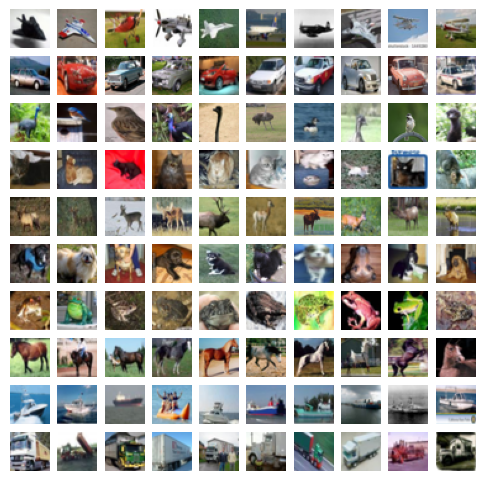

In [7]:
# LOADING CIFAR-10 DATASET
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# EXPLORING DATASET
print("Train Images:", train_images.shape, "Train Labels:", train_labels.shape)
print("Test Images:", test_images.shape, "Test Labels:", test_labels.shape)

# VISUALISING SAMPLES
# creating a 10 x 10 figure
fig, axes = plt.subplots(10, 10, figsize = (6, 6))

# plotting first 10 images of each class
for class_idx in range(10):
    class_imgs = train_images[train_labels.flatten() == class_idx][:10]
    for i in range(10):
        axes[class_idx, i].imshow(class_imgs[i])
        axes[class_idx, i].axis("off")
        
# adding class labels on the left
for i, ax in enumerate(axes[:, 0]):
    ax.set_ylabel(class_names[i], rotation = 90, size = 12)

plt.show()

## 2 Choosing a measure of success
```To control something, you need to be able to observe it. To achieve success, you must define what you mean by success—accuracy? Precision and recall? Customer-retention rate? Your metric for success will guide the choice of a loss function: what your model will optimize. It should directly align with your higher-level goals, such as the success of your business. For balanced-classification problems, where every class is equally likely, accuracy and area under the receiver operating characteristic curve (ROC AUC) are common metrics. For class-imbalanced problems, you can use precision and recall. For ranking problems or multilabel classification, you can use mean average precision. And it isn’t uncommon to have to define your own custom metric by which to measure success. To get a sense of the diversity of machine-learning success metrics and how they relate to different problem domains, it’s helpful to browse the data science competitions on Kaggle (https://kaggle.com); they showcase a wide range of problems and evaluation metrics.```

Given the description provided on CIFAR-10:
> "The test batch contains exactly 1000 randomly-selected images from each class."

<br>The CIFAR-10 dataset classes are thus balanced, allowing for the ```accuracy``` metric to be suitable. The accuracy score is calculated as follows:

$$
Accuracy = \frac{TP+TN}{TP+FP+TN+FN}
$$

<br>To analyse misclassification of any particular class, the use of ```confusion matrix``` will be implemented.

## 3 Deciding on an evaluation protocol
```Once you know what you’re aiming for, you must establish how you’ll measure your current progress. We’ve previously reviewed three common evaluation protocols:```

- Maintaining a hold-out validation set: The way to go when you have plenty of data
- Doing K-fold cross-validation: The right choice when you have too few samples for hold-out validation to be reliable
- Doing iterated K-fold validation: For performing highly accurate model evaluation when little data is available

```Just pick one of these. In most cases, the first will work well enough.```

## 4 Preparing your data
```Once you know what you’re training on, what you’re optimizing for, and how to evaluate your approach, you’re almost ready to begin training models. But first, you should format your data in a way that can be fed into a machine-learning model — here, we’ll assume a deep neural network:```

- As you saw previously, your data should be formatted as tensors
- The values taken by these tensors should usually be scaled to small values: for example, in the [-1, 1] range or [0, 1] range
- If different features take values in different ranges (heterogeneous data), then the data should be normalized
- You may want to do some feature engineering, especially for small-data problems

```Once your tensors of input data and target data are ready, you can begin to train models```

In [8]:
# flattening images and normalising data
x_train = train_images.reshape(-1, 32*32).astype("float32") / 255
x_test = test_images.reshape(-1, 32*32).astype("float32") / 255
print("x_train:", x_train)
print("x_test:", x_test)

# preparing the labels
y_train = to_categorical(train_labels, dtype ="uint8")
y_test = to_categorical(test_labels, dtype ="uint8")
print("\ny_train:", y_train)
print("y_test:", y_test)

x_train: [[0.23137255 0.24313726 0.24705882 ... 0.36078432 0.29803923 0.6862745 ]
 [0.5058824  0.41568628 0.5568628  ... 0.5176471  0.67058825 0.5254902 ]
 [0.3882353  0.64705884 0.4509804  ... 0.48235294 0.36078432 0.28235295]
 ...
 [0.8980392  0.8980392  0.9372549  ... 0.18039216 0.18039216 0.39215687]
 [0.21176471 0.22745098 0.40392157 ... 0.37254903 0.16862746 0.18431373]
 [0.20392157 0.15686275 0.18431373 ... 0.6392157  0.6392157  0.6313726 ]]
x_test: [[0.61960787 0.4392157  0.19215687 ... 0.64705884 0.6039216  0.6156863 ]
 [0.5764706  0.5372549  0.60784316 ... 0.88235295 0.52156866 0.54901963]
 [0.5647059  0.5254902  0.5529412  ... 0.08235294 0.2627451  0.43137255]
 ...
 [0.28627452 0.30588236 0.29411766 ... 0.37254903 0.30980393 0.35686275]
 [0.33333334 0.25490198 0.39215687 ... 0.33333334 0.5529412  0.5803922 ]
 [0.43137255 0.5686275  0.6        ... 0.10588235 0.10196079 0.10196079]]

y_train: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 

In [9]:
model = models.Sequential([
    layers.Dense(512, activation = "relu", input_shape = (32 * 32,)),
    layers.Dense(10, activation = "softmax") # there are 10 classes
])

In [10]:
model.compile(
    optimizer = "rmsprop",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
y_pred = model.predict(x_test)

## 5 Developing a model that does better than a baseline
```Your goal at this stage is to achieve statistical power: that is, to develop a small model that is capable of beating a dumb baseline. In the MNIST digit-classification example, anything that achieves an accuracy greater than 0.1 can be said to have statistical power; in the IMDB example, it’s anything with an accuracy greater than 0.5.```

```Note that it’s not always possible to achieve statistical power. If you can’t beat a random baseline after trying multiple reasonable architectures, it may be that the answer to the question you’re asking isn’t present in the input data. Remember that you make two hypotheses:```

- You hypothesize that your outputs can be predicted given your inputs
- You hypothesize that the available data is sufficiently informative to learn the relationship between inputs and outputs

```It may well be that these hypotheses are false, in which case you must go back to the drawing board.```
```Assuming that things go well, you need to make three key choices to build your first working model:```

- Last-layer activation: This establishes useful constraints on the network’s output. For instance, the IMDB classification example used sigmoid in the last layer; the regression example didn’t use any last-layer activation; and so on
- Loss function: This should match the type of problem you’re trying to solve. For instance, the IMDB example used binary_crossentropy, the regression example used mse, and so on
- Optimization configuration: What optimizer will you use? What will its learning rate be? In most cases, it’s safe to go with rmsprop and its default learning rate

```Regarding the choice of a loss function, note that it isn’t always possible to directly optimize for the metric that measures success on a problem. Sometimes there is no easy way to turn a metric into a loss function; loss functions, after all, need to be computable given only a mini-batch of data (ideally, a loss function should be computable for as little as a single data point) and must be differentiable (otherwise, you can’t use backpropagation to train your network). For instance, the widely used classification metric ROC AUC can’t be directly optimized. Hence, in classification tasks, it’s common to optimize for a proxy metric of ROC AUC, such as crossentropy. In general, you can hope that the lower the crossentropy gets, the higher the ROC AUC will be. Table 4.1 can help you choose a last-layer activation and a loss function for a few common problem types.```

## 6 Scaling up: developing a model that overfits
```Once you’ve obtained a model that has statistical power, the question becomes, is your model sufficiently powerful? Does it have enough layers and parameters to properly model the problem at hand? For instance, a network with a single hidden layer with two units would have statistical power on MNIST but wouldn’t be sufficient to solve the problem well. Remember that the universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.```

```To figure out how big a model you’ll need, you must develop a model that overfits. This is fairly easy:```
1. Add layers
2. Make the layers bigger
3. Train for more epochs

```Always monitor the training loss and validation loss, as well as the training and validation values for any metrics you care about. When you see that the model’s performance on the validation data begins to degrade, you’ve achieved overfitting.```

```The next stage is to start regularizing and tuning the model, to get as close as possible to the ideal model that neither underfits nor overfits.```

## 7 Regularizing your model and tuning your hyperparameters
```This step will take the most time: you’ll repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. These are some things you should try:```

- Add dropout
- Try different architectures: add or remove layers
- Add L1 and/or L2 regularization
- Try different hyperparameters (such as the number of units per layer or the learning rate of the optimizer) to find the optimal configuration
- Optionally, iterate on feature engineering: add new features, or remove features that don’t seem to be informative

```Be mindful of the following: every time you use feedback from your validation process to tune your model, you leak information about the validation process into the model. Repeated just a few times, this is innocuous; but done systematically over many iterations, it will eventually cause your model to overfit to the validation process (even though no model is directly trained on any of the validation data). This makes the evaluation process less reliable.```

```Once you’ve developed a satisfactory model configuration, you can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set. If it turns out that performance on the test set is significantly worse than the performance measured on the validation data, this may mean either that your validation procedure wasn’t reliable after all, or that you began overfitting to the validation data while tuning the parameters of the model. In this case, you may want to switch to a more reliable evaluation protocol (such as iterated K-fold validation).```

## 8 References
1. Krizhevsky, A. (2009). CIFAR-10 and CIFAR-100 datasets. [online] Toronto.edu. Available at: https://www.cs.toronto.edu/~kriz/cifar.html.
2. Bleyer, A. and Welch, H.G. (2012). Effect of Three Decades of Screening Mammography on Breast-Cancer Incidence. New England Journal of Medicine, 367(21), pp.1998–2005. doi:https://doi.org/10.1056/nejmoa1206809.